# Federated Learning for Spatio-Temporal Predictions

In [ ]:
# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# !pip install --quiet tensorflow_federated
# !pip install --quiet tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
# !pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
import datetime

In [ ]:
%load_ext tensorboard

# 1. Data Preprocessing

## 1.1 Samples (indexed by experiment)

In [ ]:
# path = '../data/avoidance_20200131_204454.dat' #10 Robots
# path = '../data/avoidance_20200131_204700.dat' #20 Robots
# path = '../data/avoidance_20200131_205449.dat' #40 Robots
# path = '../data/mixed_by_id_20200213_223611.dat' #30 Robots

samples_central = {}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    count = 0
    samples_central.update({exp_id : {}})
    samples_central[exp_id].update({count : []})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            x1 = float(data[3])
            x2 = float(data[4])
            samples_central[exp_id][count].append((x1, x2))
            # assumption that trajectories are 99 steps
            if len(samples_central[exp_id][count]) == 99:
                del samples_central[exp_id][count][98] # easier with even length
                count+=1
                samples_central[exp_id].update({count : []})
    # delete last empty trajectory
    del samples_central[exp_id][count]

## 1.2 Samples (indexed by experiment, client and collection time)

In [13]:
path = '../data/avoidance_20200131_204454.dat'#'../data/[!G_][!flocking]**.dat'
# path = '../data/flocking_20200217_123218.dat' #20 Robots
# path = '../data/foraging_20200217_113829.dat' #20 Robots
# path = '../data/avoidance_20200131_204700.dat' #20 Robots
#path = '../data/avoidance_20200131_205449.dat' #40 Robots
# path = '../data/mixed_by_id_20200213_223611.dat' #30 Robots


samples = {} #samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    last_sample_keys = {}
    samples.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = int(data[0])
            t = int(data[2])
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples[exp_id].keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[exp_id][rid]):
                    samples[exp_id][rid][last_key] = {'traj': [], 'end' : 0}
                samples[exp_id][rid][last_key]['traj'].append((x1, x2))
                samples[exp_id][rid][last_key]['end'] = t
                if len(samples[exp_id][rid][last_key]['traj']) == 99:
                    del samples[exp_id][rid][last_key]['traj'][98]
                    samples[exp_id][rid][last_key]['end'] = t
                    last_sample_keys[rid]+=1
            else:
                samples[exp_id].update({rid: {}})
                samples[exp_id][rid].update({0: {'traj': [(x1, x2)], 'end': 0}})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[exp_id][rid] and len(samples[exp_id][rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/avoidance_20200131_204454.dat


## 1.3 Communication graph 

In [ ]:
path = '../data/G_avoidance_20200131_204454.dat'

neighbors = {}  #neigbors{ <exp_id> : {<rid>: { <t> : [<neighbors>]}}

for filename in glob.iglob(path):
    print(filename)    
    exp_id = filename[-10:-4]
    neighbors.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        rid = int(data[0])
        t = int(data[1])
        nid = int(data[2])
        if(t != 0):
            if(rid not in neighbors[exp_id].keys()):
                neighbors[exp_id].update({rid: {}})
            if(t not in neighbors[exp_id][rid].keys()):
                neighbors[exp_id][rid].update({t:[]})
            neighbors[exp_id][rid][t].append(nid)

## 1.4 Format checks

In [ ]:
print(samples.keys())
print(len(samples['205449'][1].keys()))

In [ ]:
for k,v in samples['204454'].items():
    for kk, vv in v.items():
        if len(vv['traj']) != 98:
            print(len(v),len(vv['traj']))

In [ ]:
for k,v in samples_central['204700'].items():
        if len(v) != 98:
            print(k,len(v))

In [ ]:
# print(samples_central['205449'][1])
print(len(samples_central['204700'].keys()))

# 2. Model Definition

## 2.1 Parameters

In [14]:
EMBEDDING_SIZE = 32
DROP_RATE = 0.3
NUM_OUTPUTS = 2

SEQ_LENGTH = 49
DIM_INPUT = 2

In [15]:
sample_shape = (SEQ_LENGTH, DIM_INPUT)

## 2.2 Simple LSTM 

In [16]:
def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-10.,input_shape=sample_shape),
    tf.keras.layers.LSTM(EMBEDDING_SIZE,
                         return_sequences=True,
                         input_shape=sample_shape),
    tf.keras.layers.Dense(NUM_OUTPUTS)
    ])
#     tf.keras.layers.Dropout(DROP_RATE),

## 2.3 Custom loss functions (todo)

In [ ]:
def r3_bivariate_gaussian_loss(true, pred):
    """
    Rank 3 bivariate gaussian loss function
    Returns results of eq # 24 of http://arxiv.org/abs/1308.0850
    :param true: truth values with at least [mu1, mu2, sigma1, sigma2, rho]
    :param pred: values predicted from a model with the same shape requirements as truth values
    :return: the log of the summed max likelihood
    """
    x_coord = true[:, :, 0]
    y_coord = true[:, :, 1]
    mu_x = pred[:, :, 0]
    mu_y = pred[:, :, 1]

    # exponentiate the sigmas and also make correlative rho between -1 and 1.
    # eq. # 21 and 22 of http://arxiv.org/abs/1308.0850
    # analogous to https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/model.py#L326
    sigma_x = K.exp(K.abs(pred[:, :, 2]))
    sigma_y = K.exp(K.abs(pred[:, :, 3]))
    rho = K.tanh(pred[:, :, 4]) * 0.1  # avoid drifting to -1 or 1 to prevent NaN, you will have to tweak this multiplier value to suit the shape of your data

    norm1 = K.log(1 + K.abs(x_coord - mu_x))
    norm2 = K.log(1 + K.abs(y_coord - mu_y))

    variance_x = K.softplus(K.square(sigma_x))
    variance_y = K.softplus(K.square(sigma_y))
    s1s2 = K.softplus(sigma_x * sigma_y)  # very large if sigma_x and/or sigma_y are very large

    # eq 25 of http://arxiv.org/abs/1308.0850
    z = ((K.square(norm1) / variance_x) +
         (K.square(norm2) / variance_y) -
         (2 * rho * norm1 * norm2 / s1s2))  # z → -∞ if rho * norm1 * norm2 → ∞ and/or s1s2 → 0
    neg_rho = 1 - K.square(rho)  # → 0 if rho → {1, -1}
    numerator = K.exp(-z / (2 * neg_rho))  # → ∞ if z → -∞ and/or neg_rho → 0
    denominator = (2 * np.pi * s1s2 * K.sqrt(neg_rho)) + epsilon()  # → 0 if s1s2 → 0 and/or neg_rho → 0
    pdf = numerator / denominator  # → ∞ if denominator → 0 and/or if numerator → ∞
    return K.log(K.sum(-K.log(pdf + epsilon())))  # → -∞ if pdf → ∞

# 3. Datasets 

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO =  1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

## 3.1 Utilities

In [ ]:
def _create_series_examples_from_dict(data_dict, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(data_dict.values())
    array_dataset = np.asarray(list_dataset)
    for i in range(start_index, end_index):
        data.append(array_dataset[i][:history_size])
        labels.append(array_dataset[i][history_size:])
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

In [ ]:
def create_training_and_val_sets(data_dict, past_history=PAST_HISTORY, future_target=PAST_HISTORY):
    
    x_train = np.zeros((1, past_history, DIM_INPUT))
    y_train = np.zeros((1, future_target, DIM_INPUT))
    x_val = np.zeros((1, past_history, DIM_INPUT))
    y_val = np.zeros((1, future_target, DIM_INPUT))

    for v in data_dict.values():
        tot_samples = len(v)
        train_split = round(TRAIN_RATIO * tot_samples)
        x_train_tmp, y_train_tmp = _create_series_examples_from_dict(v, 0, train_split, past_history)
        x_val_tmp, y_val_tmp = _create_series_examples_from_dict(v, train_split, tot_samples, past_history)
        x_train = np.concatenate([x_train, x_train_tmp], axis=0)
        y_train = np.concatenate([y_train, y_train_tmp], axis=0)
        x_val = np.concatenate([x_val, x_val_tmp], axis=0)
        y_val = np.concatenate([y_val, y_val_tmp], axis=0)
        
    return x_train, x_val, y_train, y_val

In [ ]:
def create_datasets(x_train, x_val, y_train, y_val):
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return train_set, val_set

## 3.2 Centralized

In [ ]:
x_train_C, x_val_C, y_train_C, y_val_C = create_training_and_val_sets(samples_central)

In [ ]:
train_set_C, val_set_C = create_datasets(x_train_C, x_val_C, y_train_C, y_val_C)

In [ ]:
print(train_set_C)

# 4. Training

## 4.1 Centralized 

### 4.1.1 Utilities

In [ ]:
# Create new callback
class MyHistory(tf.keras.callbacks.Callback):
    """Adapted from https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L614"""

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.times = []
        self.history = {}
        self.start = datetime.datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        delta = float((datetime.datetime.now() - self.start).total_seconds())
        self.times.append(delta)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

### 4.1.2 Parameters

In [ ]:
EVALUATION_INTERVAL = 50
EPOCHS = 150  

### 4.1.3 Training loop

In [ ]:
# Instantiate callback
myHistory = MyHistory()

In [ ]:
simple_lstm = create_model()

In [ ]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

simple_lstm.compile(optimizer='SGD',
        loss='mean_squared_error')
simple_lstm.fit(train_set_C, epochs=EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_set_C, validation_steps=50,
              callbacks=[tensorboard_callback, myHistory])

# Note: with the regularization loss, it's normal that the validation loss is smaller than the training loss!

In [ ]:
print(myHistory)

### 4.1.4 Save Training History

In [ ]:
filehandler = open('Centralized_history_K10_avoid_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
data = {'losses' : myHistory.history, 'times' : myHistory.times}
pickle.dump(data, filehandler)
filehandler.close()

# del data
# del samples_central
# del simple_lstm
# del myHistory

In [ ]:
file = open('Centralized_history_K40_avoid_20200213-120437','rb')
test = pickle.load(file)
print(test)

## 4.2 Federated Averaging in Server Setting

### 4.2.1 Parameters

In [17]:
EXP_DURATION = 100000
LOCAL_EPOCHS = 1 # 10 100
TRAIN_FRAC = 0.8
NUM_ROUNDS = 100
ROUND_DURATION = int(EXP_DURATION / NUM_ROUNDS)

TRAIN_RATIO = 0.8
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
FUTURE_TARGET = 49

In [28]:
BATCH_SIZE = 40

In [ ]:
print(samples.keys())

In [ ]:
for i in range(1,len(samples['223611'])+1):
    print(len(samples['223611'][i]))

### 4.2.2 Utilities

In [20]:
 def _create_series_examples_from_batch(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset)
    array_dataset = np.asarray(list_dataset)
    for i in range(start_index, end_index):
        data.append(array_dataset[i][:history_size])
        labels.append(array_dataset[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

In [21]:
def create_training_and_val_batch(batch, past_history=PAST_HISTORY, future_target=PAST_HISTORY):
    
    x_train = np.zeros((1,PAST_HISTORY,2))
    y_train = np.zeros((1,FUTURE_TARGET,2))
    x_val = np.zeros((1,PAST_HISTORY,2))
    y_val = np.zeros((1,FUTURE_TARGET,2))
    for v in batch:
        tot_samples = len(v)
        train_split = round(TRAIN_RATIO * tot_samples)
#         print(len(v), train_split)
        x_train_tmp, y_train_tmp = _create_series_examples_from_batch(v, 0, train_split, PAST_HISTORY)
        x_val_tmp, y_val_tmp = _create_series_examples_from_batch(v, train_split, tot_samples, PAST_HISTORY)
        x_train = np.concatenate([x_train, x_train_tmp], axis=0)
        y_train = np.concatenate([y_train, y_train_tmp], axis=0)
        x_val = np.concatenate([x_val, x_val_tmp], axis=0)
        y_val = np.concatenate([y_val, y_val_tmp], axis=0)
        
    return x_train, x_val, y_train, y_val

In [29]:
def create_datasets_FA(x_train, x_val, y_train, y_val):
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_set = train_set.cache().batch(BATCH_SIZE).repeat()
    val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_set = val_set.cache().batch(BATCH_SIZE).repeat()
    return train_set, val_set

In [23]:
def average_weights(weights):
    avg = np.zeros_like(trainable_weights[1][1])
    count = 0
    for k,v in weights.items():
        if(len(v) != 0):
            avg = np.add(avg, v)
            count += 1
    if(count != 0):
        avg = avg/count
    avg = np.squeeze(avg)
    return avg           

In [24]:
def weighted_average_weights(weights, num_samples):
    _sum = np.zeros_like(trainable_weights[1][1])
    count = 0
    for k,v in weights.items():
        if(len(v) != 0):
            _sum = np.add(_sum, np.multiply(num_samples[k], v))
            count += num_samples[k]
    if(count != 0):
        _sum = _sum/count
    avg = np.squeeze(_sum)
    return avg        

In [ ]:
# Create new callback
class LocalHistory(tf.keras.callbacks.Callback):
    """Adapted from https://github.com/keras-team/keras/blob/master/keras/callbacks/callbacks.py#L614"""

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.times = []
        self.history = {}
        self.start = datetime.datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)
        delta = float((datetime.datetime.now() - self.start).total_seconds())
        self.times.append(delta)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

### 4.2.3 Rounds by global clock and data 

In [ ]:
from tensorflow.keras.models import load_model

In [30]:
history = {}
local_lstm = create_model()

# For each experiment
for exp in samples.keys():
    
    history.update({exp : {}})
    
    # Per experiment settings 
    num_robots = len(samples[exp].keys())
    
    for i in range(1, num_robots + 1):
        history[exp].update({i : {}})

    # Set global clock to 0
    global_clock = 0
    round_num = 1
    
    # Initialize weights
    trainable_weights = {}
    arr_num_samples = {}
    w  = [v.numpy() for v in local_lstm.trainable_weights]
    w_list = [[w] for i in range(num_robots)]
    trainable_weights[0] = {}
    arr_num_samples[0] = {}
    trainable_weights[round_num] = {k : v for (k, v) in zip(range(1, num_robots + 1), w_list)}
    arr_num_samples[round_num] = {k : 1 for (k, v) in zip(range(1, num_robots + 1), w_list)}
    leftover_samples_buffer = {}
    
    # buffer of last data index of previous round for each robot
    last_idx_previous_round = np.zeros(num_robots, dtype=int)
    
    for t in range(ROUND_DURATION, EXP_DURATION, ROUND_DURATION):
        
        print("_______________________")
        print("Round ", round_num)
        print("_______________________")
        
        # One round for each robot: data collection, local training and global update
        for i in samples[exp].keys():
            
            print("Robot ", i)
            
            batch = []
            
            # Get data index at time of round
            cond = True
            current_idx =  last_idx_previous_round[i-1]
            while(cond):
                current_idx+=1
                if(samples[exp][i][current_idx]['end'] > t):
                    cond = False
            
            num_samples = current_idx - last_idx_previous_round[i-1]
            
            print("Num samples", num_samples)
            
             # Check that we have enough data collected to participate in the round
            if(num_samples >= BATCH_SIZE):
                # Take extra data collected before end of round
                tmp = [samples[exp][i][j]['traj'] for j in range(last_idx_previous_round[i-1], current_idx)]
                batch.append(tmp)
                %xdel tmp
                # Take remaining data from previous round
                if(i in leftover_samples_buffer.keys() and len(leftover_samples_buffer[i]) > 0):
                    batch.append(leftover_samples_buffer[i])
                    leftover_samples_buffer[i] = []
            # Check that we have enough previous data      
            elif(i in leftover_samples_buffer.keys() 
                 and (len(leftover_samples_buffer[i]) + num_samples) >= BATCH_SIZE): 
                batch.append(leftover_samples_buffer[i])
                leftover_samples_buffer[i] = []
            else:
                if(i not in leftover_samples_buffer.keys()):
                    leftover_samples_buffer.update({i: []})
                leftover_samples_buffer[i] = [samples[exp][i][j]['traj'] for j in range(last_idx_previous_round[i-1], current_idx)]
                last_idx_previous_round[i-1] = current_idx
                print('Robot not participating', i)
                continue
            last_idx_previous_round[i-1] = current_idx
            
            # Get weights
            current_weights = weighted_average_weights(trainable_weights[round_num], arr_num_samples[round_num])
#             current_weights = average_weights(trainable_weights[round_num])
            
            # Perform local training
            # Create datasets
            x_train_FA, x_val_FA, y_train_FA, y_val_FA = create_training_and_val_batch(batch)
            train_batch, val_batch = create_datasets_FA(x_train_FA, x_val_FA, y_train_FA, y_val_FA)
            # Clone simple_lstm and initialize it with newest weights
            local_lstm = tf.keras.models.load_model('lstm.h5', compile=False)
            keras_model_clone = tf.keras.models.clone_model(local_lstm)
            keras_model_clone.compile(optimizer='SGD', loss='mean_absolute_error')
            keras_model_clone.set_weights(current_weights)
            robot_history = keras_model_clone.fit(train_batch, epochs=LOCAL_EPOCHS,
              steps_per_epoch=len(x_train_FA),
              validation_data=val_batch, 
              validation_steps=len(x_val_FA))#,
#              callbacks=[l_history])
            # Write weights 
            if((round_num+1) not in trainable_weights.keys()):
                trainable_weights.update({(round_num+1): {}})
                arr_num_samples.update({(round_num+1): {}})
            trainable_weights[round_num+1].update({i: keras_model_clone.get_weights()})
            arr_num_samples[round_num+1].update({i: num_samples})
            # Write metrics
            history[exp][i].update({round_num : { 'losses': robot_history.history, 'num_samples': num_samples}})
            %xdel current_weights
            %xdel robot_history          
            %xdel train_batch
            %xdel val_batch
            %xdel batch
            %xdel x_train_FA
            %xdel x_val_FA
            %xdel y_train_FA
            %xdel y_val_FA
            %xdel keras_model_clone
            %xdel local_lstm
            tf.keras.backend.clear_session()
        round_num+=1

_______________________
Round  1
_______________________
Robot  1
Num samples 24
Robot not participating 1
Robot  10
Num samples 22
Robot not participating 10
Robot  2
Num samples 23
Robot not participating 2
Robot  3
Num samples 30
Robot not participating 3
Robot  4
Num samples 28
Robot not participating 4
Robot  5
Num samples 23
Robot not participating 5
Robot  6
Num samples 25
Robot not participating 6
Robot  7
Num samples 40
Train for 33 steps, validate for 9 steps
33/33 [==============================] - 4s 110ms/step - loss: 1.0570 - val_loss: 0.8823
Robot  8
Num samples 24
Robot not participating 8
Robot  9
Num samples 31
Robot not participating 9
_______________________
Round  2
_______________________
Robot  1
Num samples 31
Train for 20 steps, validate for 6 steps
20/20 [==============================] - 3s 131ms/step - loss: 0.8528 - val_loss: 0.5741
Robot  10
Num samples 38
Train for 19 steps, validate for 5 steps
19/19 [==============================] - 3s 167ms/step - los

Train for 35 steps, validate for 9 steps
35/35 [==============================] - 2s 65ms/step - loss: 0.1215 - val_loss: 0.0941
_______________________
Round  9
_______________________
Robot  1
Num samples 24
Robot not participating 1
Robot  10
Num samples 44
Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 88ms/step - loss: 0.1065 - val_loss: 0.1031
Robot  2
Num samples 40
Train for 63 steps, validate for 16 steps
63/63 [==============================] - 3s 45ms/step - loss: 0.1145 - val_loss: 0.1131
Robot  3
Num samples 36
Robot not participating 3
Robot  4
Num samples 34
Robot not participating 4
Robot  5
Num samples 19
Robot not participating 5
Robot  6
Num samples 36
Robot not participating 6
Robot  7
Num samples 31
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 3s 115ms/step - loss: 0.0986 - val_loss: 0.1465
Robot  8
Num samples 8
Robot not participating 8
Robot  9
Num samples 30
Robot not participating 9
__

Train for 57 steps, validate for 15 steps
57/57 [==============================] - 5s 93ms/step - loss: 0.0924 - val_loss: 0.0844
_______________________
Round  17
_______________________
Robot  1
Num samples 44
Train for 62 steps, validate for 17 steps
62/62 [==============================] - 4s 57ms/step - loss: 0.0875 - val_loss: 0.0935
Robot  10
Num samples 32
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 121ms/step - loss: 0.0827 - val_loss: 0.0820
Robot  2
Num samples 42
Train for 63 steps, validate for 16 steps
63/63 [==============================] - 3s 47ms/step - loss: 0.0871 - val_loss: 0.0829
Robot  3
Num samples 43
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 93ms/step - loss: 0.0837 - val_loss: 0.0858
Robot  4
Num samples 39
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 2s 80ms/step - loss: 0.0816 - val_loss: 0.1036
Robot  5
Num samples 8
Robot not participa

Train for 36 steps, validate for 10 steps
36/36 [==============================] - 3s 92ms/step - loss: 0.0689 - val_loss: 0.0770
Robot  2
Num samples 47
Train for 39 steps, validate for 10 steps
39/39 [==============================] - 2s 62ms/step - loss: 0.0746 - val_loss: 0.0742
Robot  3
Num samples 37
Robot not participating 3
Robot  4
Num samples 37
Robot not participating 4
Robot  5
Num samples 18
Robot not participating 5
Robot  6
Num samples 43
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 94ms/step - loss: 0.0742 - val_loss: 0.0826
Robot  7
Num samples 32
Robot not participating 7
Robot  8
Num samples 10
Robot not participating 8
Robot  9
Num samples 35
Robot not participating 9
_______________________
Round  25
_______________________
Robot  1
Num samples 34
Train for 21 steps, validate for 6 steps
21/21 [==============================] - 2s 101ms/step - loss: 0.0713 - val_loss: 0.0487
Robot  10
Num samples 30
Robot not participating 1

59/59 [==============================] - 4s 63ms/step - loss: 0.0651 - val_loss: 0.0612
_______________________
Round  32
_______________________
Robot  1
Num samples 43
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 4s 113ms/step - loss: 0.0603 - val_loss: 0.0572
Robot  10
Num samples 35
Robot not participating 10
Robot  2
Num samples 41
Train for 61 steps, validate for 16 steps
61/61 [==============================] - 4s 59ms/step - loss: 0.0618 - val_loss: 0.0586
Robot  3
Num samples 49
Train for 40 steps, validate for 11 steps
40/40 [==============================] - 4s 106ms/step - loss: 0.0596 - val_loss: 0.0482
Robot  4
Num samples 29
Robot not participating 4
Robot  5
Num samples 13
Robot not participating 5
Robot  6
Num samples 42
Train for 35 steps, validate for 9 steps
35/35 [==============================] - 3s 75ms/step - loss: 0.0636 - val_loss: 0.0533
Robot  7
Num samples 35
Train for 27 steps, validate for 8 steps
27/27 [=============

Robot  4
Num samples 36
Train for 29 steps, validate for 8 steps
29/29 [==============================] - 3s 105ms/step - loss: 0.0649 - val_loss: 0.0623
Robot  5
Num samples 19
Robot not participating 5
Robot  6
Num samples 43
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 2s 66ms/step - loss: 0.0656 - val_loss: 0.0576
Robot  7
Num samples 41
Train for 34 steps, validate for 9 steps
34/34 [==============================] - 3s 93ms/step - loss: 0.0696 - val_loss: 0.0624
Robot  8
Num samples 10
Robot not participating 8
Robot  9
Num samples 35
Robot not participating 9
_______________________
Round  40
_______________________
Robot  1
Num samples 33
Train for 23 steps, validate for 6 steps
23/23 [==============================] - 2s 88ms/step - loss: 0.0713 - val_loss: 0.0437
Robot  10
Num samples 32
Robot not participating 10
Robot  2
Num samples 28
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 3s 105ms/step - loss

20/20 [==============================] - 2s 98ms/step - loss: 0.0574 - val_loss: 0.0773
Robot  2
Num samples 32
Robot not participating 2
Robot  3
Num samples 22
Train for 18 steps, validate for 5 steps
18/18 [==============================] - 3s 159ms/step - loss: 0.0611 - val_loss: 0.0565
Robot  4
Num samples 26
Train for 20 steps, validate for 6 steps
20/20 [==============================] - 2s 102ms/step - loss: 0.0580 - val_loss: 0.0652
Robot  5
Num samples 25
Robot not participating 5
Robot  6
Num samples 29
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 123ms/step - loss: 0.0500 - val_loss: 0.0509
Robot  7
Num samples 28
Train for 17 steps, validate for 5 steps
17/17 [==============================] - 2s 112ms/step - loss: 0.0529 - val_loss: 0.0422
Robot  8
Num samples 29
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 3s 113ms/step - loss: 0.0567 - val_loss: 0.0602
Robot  9
Num samples 31
Robot not particip

Train for 27 steps, validate for 7 steps
27/27 [==============================] - 3s 120ms/step - loss: 0.0493 - val_loss: 0.0570
_______________________
Round  55
_______________________
Robot  1
Num samples 35
Train for 22 steps, validate for 6 steps
22/22 [==============================] - 2s 98ms/step - loss: 0.0529 - val_loss: 0.0366
Robot  10
Num samples 24
Train for 19 steps, validate for 6 steps
19/19 [==============================] - 3s 160ms/step - loss: 0.0559 - val_loss: 0.0328
Robot  2
Num samples 24
Robot not participating 2
Robot  3
Num samples 22
Train for 19 steps, validate for 6 steps
19/19 [==============================] - 2s 104ms/step - loss: 0.0516 - val_loss: 0.0316
Robot  4
Num samples 24
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 3s 121ms/step - loss: 0.0582 - val_loss: 0.0522
Robot  5
Num samples 30
Robot not participating 5
Robot  6
Num samples 32
Train for 23 steps, validate for 7 steps
23/23 [========================

Robot  3
Num samples 23
Robot not participating 3
Robot  4
Num samples 26
Robot not participating 4
Robot  5
Num samples 25
Train for 24 steps, validate for 7 steps
24/24 [==============================] - 3s 118ms/step - loss: 0.0497 - val_loss: 0.0579
Robot  6
Num samples 30
Robot not participating 6
Robot  7
Num samples 27
Robot not participating 7
Robot  8
Num samples 29
Robot not participating 8
Robot  9
Num samples 37
Train for 28 steps, validate for 8 steps
28/28 [==============================] - 4s 142ms/step - loss: 0.0477 - val_loss: 0.0561
_______________________
Round  63
_______________________
Robot  1
Num samples 26
Train for 31 steps, validate for 8 steps
31/31 [==============================] - 3s 91ms/step - loss: 0.0506 - val_loss: 0.0486
Robot  10
Num samples 23
Train for 17 steps, validate for 5 steps
17/17 [==============================] - 3s 190ms/step - loss: 0.0540 - val_loss: 0.0570
Robot  2
Num samples 30
Robot not participating 2
Robot  3
Num samples 23
Tr

Robot  8
Num samples 21
Train for 24 steps, validate for 7 steps
24/24 [==============================] - 3s 126ms/step - loss: 0.0497 - val_loss: 0.0376
Robot  9
Num samples 25
Train for 30 steps, validate for 8 steps
30/30 [==============================] - 3s 86ms/step - loss: 0.0467 - val_loss: 0.0534
_______________________
Round  70
_______________________
Robot  1
Num samples 35
Robot not participating 1
Robot  10
Num samples 24
Robot not participating 10
Robot  2
Num samples 26
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 133ms/step - loss: 0.0478 - val_loss: 0.0418
Robot  3
Num samples 21
Robot not participating 3
Robot  4
Num samples 25
Robot not participating 4
Robot  5
Num samples 31
Train for 27 steps, validate for 7 steps
27/27 [==============================] - 3s 104ms/step - loss: 0.0512 - val_loss: 0.0428
Robot  6
Num samples 33
Robot not participating 6
Robot  7
Num samples 23
Robot not participating 7
Robot  8
Num samples 31
R

Train for 18 steps, validate for 5 steps
18/18 [==============================] - 2s 117ms/step - loss: 0.0514 - val_loss: 0.0526
Robot  4
Num samples 25
Train for 22 steps, validate for 6 steps
22/22 [==============================] - 4s 162ms/step - loss: 0.0493 - val_loss: 0.0501
Robot  5
Num samples 23
Robot not participating 5
Robot  6
Num samples 32
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 127ms/step - loss: 0.0465 - val_loss: 0.0490
Robot  7
Num samples 25
Train for 19 steps, validate for 5 steps
19/19 [==============================] - 2s 117ms/step - loss: 0.0520 - val_loss: 0.0424
Robot  8
Num samples 29
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 3s 129ms/step - loss: 0.0502 - val_loss: 0.0510
Robot  9
Num samples 38
Train for 25 steps, validate for 7 steps
25/25 [==============================] - 2s 89ms/step - loss: 0.0504 - val_loss: 0.0372
_______________________
Round  78
_________________

Train for 22 steps, validate for 6 steps
22/22 [==============================] - 3s 150ms/step - loss: 0.0483 - val_loss: 0.0325
Robot  10
Num samples 25
Train for 19 steps, validate for 6 steps
19/19 [==============================] - 2s 109ms/step - loss: 0.0484 - val_loss: 0.0282
Robot  2
Num samples 29
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 117ms/step - loss: 0.0460 - val_loss: 0.0432
Robot  3
Num samples 22
Train for 21 steps, validate for 6 steps
21/21 [==============================] - 2s 115ms/step - loss: 0.0444 - val_loss: 0.0357
Robot  4
Num samples 27
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 131ms/step - loss: 0.0483 - val_loss: 0.0442
Robot  5
Num samples 34
Robot not participating 5
Robot  6
Num samples 33
Train for 24 steps, validate for 7 steps
24/24 [==============================] - 3s 135ms/step - loss: 0.0449 - val_loss: 0.0484
Robot  7
Num samples 23
Train for 28 steps, valid

Robot  10
Num samples 23
Robot not participating 10
Robot  2
Num samples 43
Train for 35 steps, validate for 10 steps
35/35 [==============================] - 3s 84ms/step - loss: 0.0463 - val_loss: 0.0548
Robot  3
Num samples 26
Robot not participating 3
Robot  4
Num samples 27
Robot not participating 4
Robot  5
Num samples 23
Train for 26 steps, validate for 7 steps
26/26 [==============================] - 3s 123ms/step - loss: 0.0455 - val_loss: 0.0420
Robot  6
Num samples 33
Robot not participating 6
Robot  7
Num samples 27
Robot not participating 7
Robot  8
Num samples 32
Robot not participating 8
Robot  9
Num samples 41
Train for 34 steps, validate for 9 steps
34/34 [==============================] - 2s 73ms/step - loss: 0.0430 - val_loss: 0.0499
_______________________
Round  93
_______________________
Robot  1
Num samples 27
Robot not participating 1
Robot  10
Num samples 24
Train for 19 steps, validate for 6 steps
19/19 [==============================] - 3s 153ms/step - loss: 

Robot  8
Num samples 24
Train for 27 steps, validate for 8 steps
27/27 [==============================] - 3s 95ms/step - loss: 0.0444 - val_loss: 0.0391
Robot  9
Num samples 30
Robot not participating 9


### 4.2.4 Save training data

In [31]:
data = {}
for exp in history:
    data.update({exp : {} })
    for round_num in range(1, NUM_ROUNDS):
        data[exp].update({round_num: {}})
        for robot in history[exp]:
            if (round_num in history[exp][robot].keys()):
                data[exp][round_num].update({robot : {}})
                data[exp][round_num][robot] = {'losses' : history[exp][robot][round_num]['losses'], 'num_samples' : history[exp][robot][round_num]['num_samples']}

In [32]:
filehandler = open('FA_history_' + str(num_robots) + '_' + str(BATCH_SIZE) + '_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(data, filehandler)
filehandler.close()

## 4.3 Serverless Federated Averaging

In [ ]:
class VSElem():
    def __init__(self, data, t, i):
        self.data = data
        self.timestamp = t
        self.rid = i

class VirtualStigmery():
    def __init__(self, vid):
        self.id = vid
        self.dict = {}
        
#     def put():
    
    
#     def __call__():

# 1) vstig : key = round_num, data = < num_writes, weights_average > and store last 
#    round participated in (but conflicts problematic)
# 2) vstig : key = round_num, data = < rid_list, weights > and last round participated in (but increased load)
# 3) vstig : id = round_num, key = rid, data = < weights > and last round participated in (but delay in getting
# the newest round? or possible to start a wrong round)
# Furthermore, to avoid conflicts, do we stop at exactly a certain number of participants for the weight average?
# one vstig (1-2) or one per round (3) ? or CRDT after all ?
        

In [ ]:
    # Un-synch clocks by random integer (todo)
    time_offsets = np.random.randint(0, 10, size=(num_robots,))

# 5. Inference and Evaluation

## 5.0 Datasets

In [ ]:
print(samples['223611'][1].keys())

1
2
3
4
5
6
7
8
9
10


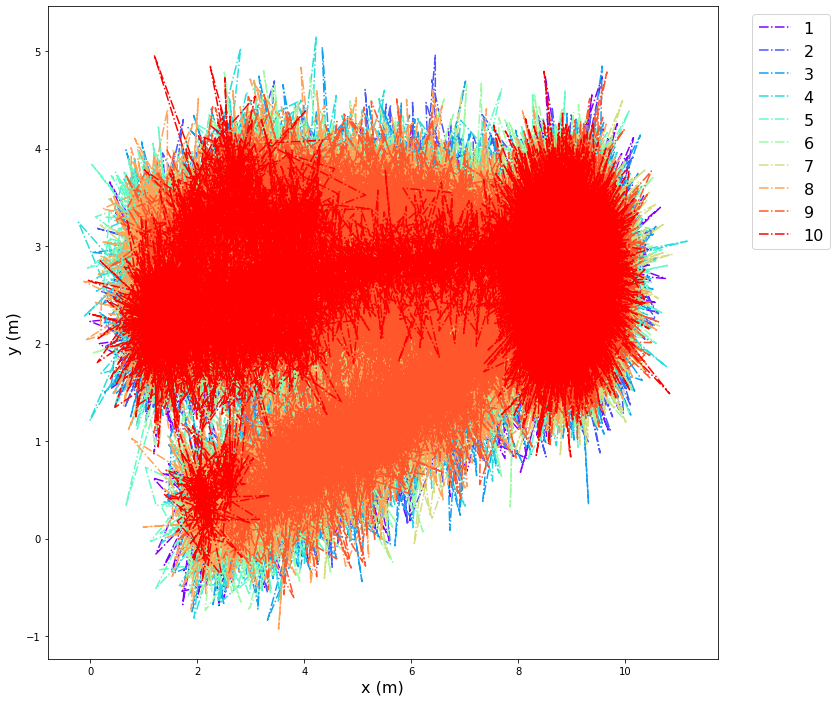

In [12]:
# samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}

plt.figure(figsize=(12, 12))
for v in samples.keys():
    colors = cm.rainbow(np.linspace(0, 1, len(samples[v].keys())))
    cnt = 0
    for r in samples[v].keys():        
        for i in samples[v][r].keys():
            traj = samples[v][r][i]['traj']
            if (len(traj) > 0):
                x, y = zip(*traj)
                ax, = plt.plot(x, y, '-.', color=colors[cnt])
            if(i > 1000):
                break
        cnt += 1
        print(cnt)
        ax.set_label(str(cnt))
#             break
    
# ax = plt.gca()

# circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
# ax.add_artist(circle2)
# plt.axis('square')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=16)
# plt.legend(loc='best', fontsize=16)
plt.xlabel('x (m)', FontSize=16)
plt.ylabel('y (m)', FontSize=16)
plt.show()


## 5.1 Validation Loss Curve

### 5.1.1 Pre-Processing

In [ ]:
filehandler = open('FA_history_10_30_20200214-182645', 'rb') 
FA = pickle.load(filehandler)
filehandler.close()

In [ ]:
avg_val_loss = np.zeros(NUM_ROUNDS)

for exp in FA.keys():
    for round_num in range(1, NUM_ROUNDS):
        count = 0.
        sum_loss = 0.
        for robot in FA[exp].keys():
            if (robot in FA[exp][round_num].keys()):
#                 print(robot, round_num, FA[exp][round_num][robot]['losses']['val_loss'])
                num_samples = FA[exp][round_num][robot]['num_samples']
                count += num_samples
                sum_loss += num_samples * FA[exp][round_num][robot]['losses']['val_loss'][0]
        if(count != 0):
            avg_val_loss[round_num - 1] = sum_loss/count
        

In [ ]:
print(avg_val_loss)

In [ ]:
filehandler = open('Centralized_history_K10_avoid_20200215-150652', 'rb') 
centralized = pickle.load(filehandler)
filehandler.close()

In [ ]:
print(centralized['times'])

### 5.1.2 Plot

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
loss_C = centralized['losses']['val_loss']
# epochs_C = centralized.epoch
plt.plot(loss_C[0:100], 'bv-', label='Centralized')
plt.plot(avg_val_loss[avg_val_loss!=0], 'r*-', label='FA')
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
plt.ylabel('Validation Loss', FontSize=16)

## 5.2 Varying Partition Size 

In [34]:
filehandler = open('FA_history_10_10_20200217-154045', 'rb') 
B1 = pickle.load(filehandler)
filehandler.close()

filehandler = open('FA_history_10_30_20200214-182645', 'rb') 
B2 = pickle.load(filehandler)
filehandler.close()

filehandler = open('FA_history_10_40_20200217-161531', 'rb') 
B3 = pickle.load(filehandler)
filehandler.close()

filehandler = open('Centralized_history_K10_avoid_20200215-150652', 'rb') 
centralized = pickle.load(filehandler)
filehandler.close()

In [35]:
def compute_loss(FA):
    avg_val_loss = np.zeros(NUM_ROUNDS)
    for exp in FA.keys():
        for round_num in range(1, NUM_ROUNDS):
            count = 0.
            sum_loss = 0.
            for robot in FA[exp].keys():
                if (robot in FA[exp][round_num].keys()):
    #                 print(robot, round_num, FA[exp][round_num][robot]['losses']['val_loss'])
                    num_samples = FA[exp][round_num][robot]['num_samples']
                    count += num_samples
                    sum_loss += num_samples * FA[exp][round_num][robot]['losses']['val_loss'][0]
            if(count != 0):
                avg_val_loss[round_num - 1] = sum_loss/count
    return avg_val_loss

Text(0, 0.5, 'Validation Loss')

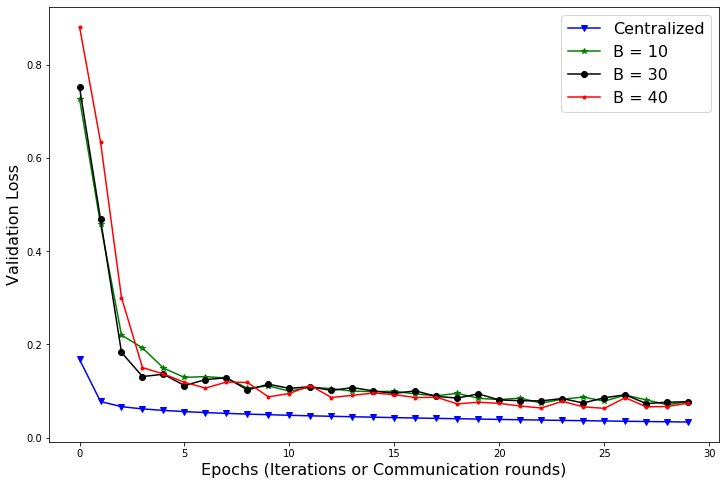

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
loss_C = centralized['losses']['val_loss']
# epochs_C = centralized.epoch
plt.plot(loss_C[0:30], 'bv-', label='Centralized')
avg_val_loss = compute_loss(B1)
plt.plot(avg_val_loss[0:30], 'g*-', label='B = 10')
avg_val_loss = compute_loss(B2)
plt.plot(avg_val_loss[0:30], 'ko-', label='B = 30')
avg_val_loss = compute_loss(B3)
plt.plot(avg_val_loss[0:30], 'r.-', label='B = 40')
plt.legend(loc='upper right', fontsize=16)
plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
plt.ylabel('Validation Loss', FontSize=16)

## 5.3 Runtime Curve

Text(0, 0.5, 'Duration (s)')

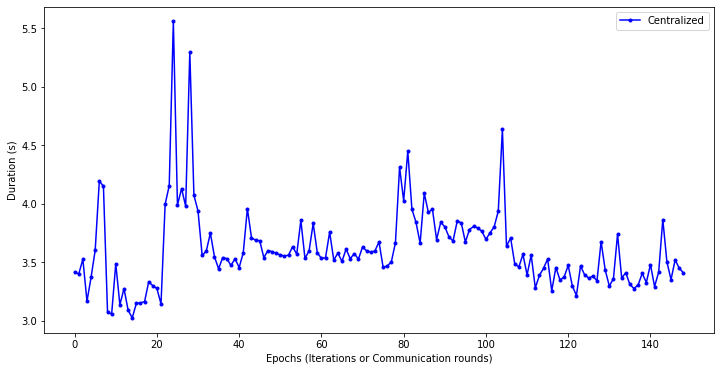

In [47]:
fig = plt.figure(figsize=(12, 6))
# ax = plt.gca()
# runtimes_C = np.diff(myHistory.times)#.total_seconds() * 1000)
# runtimes_C_s = [float(v.total_seconds())  for v in runtimes_C] 
runtimes_C_s = centralized['times']
# epochs_C = myHistory.epoch[1:]
plt.plot(np.diff(runtimes_C_s), 'b.-', label='Centralized')
plt.legend(loc='upper right')
plt.xlabel('Epochs (Iterations or Communication rounds)')
plt.ylabel('Duration (s)')

## 5.4 Predictions

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):

    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_xlim([-10,10])
    ax.set_ylim([-2,2])
    
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, history[:, 0], 'b', label='History_x')
    plt.plot(num_in, history[:, 1], 'b', label='History_y')
    plt.plot(np.arange(num_out), true_future, 'bo-',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), prediction, 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
def multi_step_plot_3D(history, true_future, prediction):
    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-10,10])
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    ax.plot3D(np.array(history[:, 0]), np.array(history[:, 1]), num_in, 'bo-', label='History')
    ax.plot3D(np.array(true_future[:,0]), np.array(true_future[:,1]), np.arange(num_out), 'bo',
           label='True Future')
    if prediction.any():
        ax.plot3D(np.array(prediction[:,0]), np.array(prediction[:,1]), np.arange(num_out), 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
# Stanford validation set
for x, y in val_set.take(3):
    multi_step_plot_3D(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])
    multi_step_plot(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])

# OLD CODE

# 2. Client-partioned Federated Learning from Trajectory Data

## 2.1 Load Distributed Data

In [ ]:
path = '../data/short_data/avoidance_20200127_1615**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {}
last_sample_keys = {}

for filename in glob.iglob(path):
    print(filename)
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = data[0]
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples.keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[rid]):
                    samples[rid][last_key] = []
                samples[rid][last_key].append((x1, x2))
                if len(samples[rid][last_key]) == 99:
                    del samples[rid][last_key][98]
                    last_sample_keys[rid]+=1
            else:
                samples.update({rid: {}})
                samples[rid].update({0: [(x1, x2)]})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[rid] and len(samples[rid][last_key]) != 0):
                last_sample_keys[rid]+=1

## 2.3 Visualize Data

In [ ]:
count_traj = sum(len(v) for v in samples.values())

print(count_traj)

In [ ]:
for k,v in samples.items():
    for kk, vv in v.items():
        if len(vv) != 98:
            print(len(v),len(vv))

## 2.4 Create Labels

In [ ]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 2.5 Create tff Dataset and tf Dataset Per Client

In [ ]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [ ]:
count = 1
dict_train_dataset = {}
dict_val_dataset = {}
for v in samples.values():
    tot_samples = round(len(v)/5)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train, y_train = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val, y_val = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    dict_train_dataset.update({count: (x_train, y_train)})
    dict_val_dataset.update({count: (x_val, y_val)})
    count+=1
    
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#     train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#     val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#     val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
print(x_train.shape, y_train.shape)

In [ ]:
tff_train_set = tff.simulation.FromTensorSlicesClientData(dict_train_dataset)
tff_val_set = tff.simulation.FromTensorSlicesClientData(dict_val_dataset)

In [ ]:
filehandler = open('tff_train_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_train_set, filehandler)
filehandler = open('tff_val_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_val_set, filehandler)

In [ ]:
print(tff_train_set.client_ids)
print(tff_train_set._output_shapes)
# print(vars(tff_train_set))

In [ ]:
def preprocess(dataset):
    return (
      dataset.cache()
      #form minibatches
      .batch(BATCH_SIZE))

In [ ]:
example_dataset = train_set

In [ ]:
print(example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

In [ ]:
def data(client, source=tff_train_set):
    return preprocess(source.create_tf_dataset_for_client(client)).take(2)

clients = [1, 2, 3]

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(
    lambda d1, d2: d1.concatenate(d2),
    [data(client, tff_val_set) for client in clients])

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
tff.framework.set_default_executor(tff.framework.create_local_executor())

## Serialize the keras model into a tff model

In [ ]:
BATCH_SIZE=16
SEQ_LENGTH=49

In [ ]:
#del simple_lstm_model
simple_lstm_model = tf.keras.models.load_model('pretrained_lstm.h5', compile=False)

In [ ]:
def tff_model():
    x = tf.constant(np.random.uniform(-2., 2., size=[BATCH_SIZE, SEQ_LENGTH, 2]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone =tf.keras.models.clone_model(simple_lstm_model)
    keras_model_clone.compile(optimizer='adam', loss='mean_absolute_error')
    return tff.learning.from_compiled_keras_model(keras_model_clone,dummy_batch)

In [ ]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=tff_model)

In [ ]:
state = fed_avg.initialize()

In [ ]:
state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in simple_lstm_model.trainable_weights],
    non_trainable_weights=[
        v.numpy() for v in simple_lstm_model.non_trainable_weights
    ])

In [ ]:
NUM_ROUNDS=3
simple_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(simple_lstm_model, state.model)
    print('Evaluating before training round', round_num)
    simple_lstm_model.evaluate(example_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    # N.B. The TFF runtime is currently fairly slow,
    # expect this to get significantly faster in future releases.
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

# 3. Continuous Data Collection and Multi-Hop Network

## 3.3 Simulation

In [ ]:
print(neighbors['205449'][1][3])

# 4. Graphs

## 4.1 Centralized Version

## Average Consensus

# Suggested extensions

This tutorial is just the first step! Here are some ideas for how you might try extending this notebook:
  * Write a more realistic training loop where you sample clients to train on randomly.
  * Use "`.repeat(NUM_EPOCHS)`" on the client datasets to try multiple epochs of local training (e.g., as in [McMahan et. al.](https://arxiv.org/abs/1602.05629)). See also [Federated Learning for Image Classification](federated_learning_for_image_classification.md) which does this.
  * Change the `compile()` command to experiment with using different optimization algorithms on the client.
  * Try the `server_optimizer` argument to `build_federated_averaging_process` to try different algorithms for applying the model updates on the server.
  * Try the `client_weight_fn` argument to to `build_federated_averaging_process` to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. `client_weight_fn=lambda _: tf.constant(1.0)`.

## Redis

In [ ]:
import redis

In [ ]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [ ]:
# r.keys()
r.set('foo', 'bar')

In [ ]:
r.get('foo')

In [ ]:
%timeit r.set('foo', 'bar')